In [2]:
## Like many great ideas, the idea for this project arose from anger.
## After waiting for over 20 minutes outside of St Patrick station for my streetcar, I decided to look into how often and how much streetcars are delayed, which routes are impacted most, and on which days I should just ride my bike instead.

In [3]:
## Importing necessary libraries, as well as TTC delay data, from Open Data Toronto

In [4]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [5]:
delays2023 = pd.read_excel('ttc_tram_delay_2023.xlsx')
delays2022 = pd.read_excel('ttt_tram_delay_2022.xlsx')
delays = delays2022.append(delays2023)

In [6]:
## data cleanup as there are several entries not associated with a specific line
delays = delays[((delays['Line'] == 501) | (delays['Line'] == 504) | (delays['Line'] == 505) | (delays['Line'] == 506) | (delays['Line'] == 503) | (delays['Line'] == 508) | (delays['Line'] == 509) | (delays['Line'] == 510) | (delays['Line'] == 511) | (delays['Line'] == 512))]

In [7]:
# Sharing with cars is cited as a reason for slow streetcars, so adding a Right-of-way indicator
delays.loc[(delays['Line'] == 509) | (delays['Line'] == 510) | (delays['Line'] == 512), 'ROW'] = 'Yes'
delays.loc[(delays['Line'] == 501) | (delays['Line'] == 504) | (delays['Line'] == 505) | (delays['Line'] == 506) | (delays['Line'] == 503) | (delays['Line'] == 508) | (delays['Line'] == 511), 'ROW'] = 'No'

In [8]:
delays.head()

,Date,Line,Time,Day,Location,Incident,Min Delay,Min Gap,Bound,Vehicle,ROW
0,2022-01-01,504,02:21,Saturday,BROADVIEW STATION,Collision - TTC Involved,30,60,E,8333,No
1,2022-01-01,501,03:22,Saturday,718 QUEEN ST EAST,Operations,16,35,W,8068,No
2,2022-01-01,504,03:28,Saturday,BROADVIEW STATION,Operations,18,36,S,0,No
3,2022-01-01,510,03:34,Saturday,UNION STATION,Operations,30,60,NaN,4406,Yes
5,2022-01-01,501,03:42,Saturday,BROADVIEW AND GERRARD,Operations,10,20,W,8847,No


In [9]:
# Check for null values. Not missing data expect for Bound (due to some streetcars possibly being delayed at stations)
delays.isna().sum()

Date            0
Line            0
Time            0
Day             0
Location        0
Incident        0
Min Delay       0
Min Gap         0
Bound        3092
Vehicle         0
ROW             0
dtype: int64

In [10]:
delays['Incident'].unique()

array(['Collision - TTC Involved', 'Operations', 'Security', 'Mechanical',
       'Cleaning - Unsanitary', 'Held By', 'Utilized Off Route',
       'General Delay', 'Diversion', 'Emergency Services',
       'Investigation', 'Late Entering Service', 'Overhead',
       'Rail/Switches', 'Cleaning - Disinfection'], dtype=object)

In [11]:
delays['Incident'].value_counts()

Operations                  7725
Mechanical                  1760
General Delay               1654
Security                    1347
Held By                     1172
Emergency Services          1092
Cleaning - Unsanitary       1016
Diversion                    843
Utilized Off Route           629
Collision - TTC Involved     593
Investigation                216
Overhead                     100
Late Entering Service         55
Rail/Switches                 42
Cleaning - Disinfection        1
Name: Incident, dtype: int64

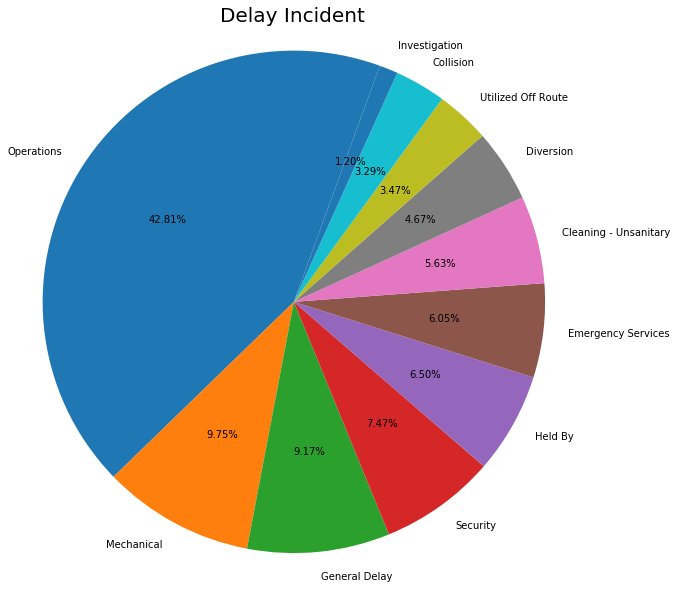

In [12]:
# Pie chart displaying overview of Incident types. Omitted incident types with 100 records or less 

labels = 'Operations', 'Mechanical', 'General Delay' , 'Security', 'Held By', 'Emergency Services', 'Cleaning - Unsanitary', 'Diversion', 'Utilized Off Route', 'Collision', 'Investigation'
size = [7725, 1760, 1654, 1347, 1172, 1092, 1016, 843, 626, 593, 216]

f, ax = plt.subplots(1,1, figsize= (10,10))

ax.pie(size, labels = labels, autopct = '%1.2f%%', startangle = 70)
ax.axis('equal')
ax.set_title("Delay Incident", size = 20)

plt.show()

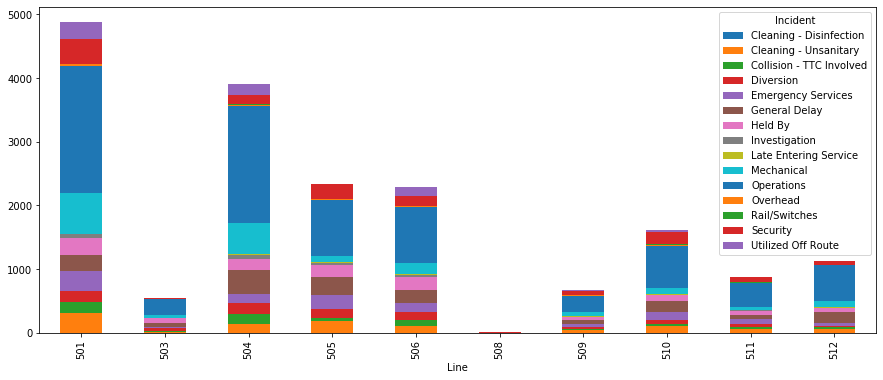

In [13]:
# to break down the above pie chart further, this chart shows incident types by line
# Operations dominates most incident types for all lines


delays.groupby('Line')['Incident'].value_counts().unstack().plot(kind = 'bar', 
                                                                stacked = True, 
                                                                figsize = (15, 6))

In [14]:
# Operations, Mechanical, and General Delay have highest counts, but do they account for the most time wasted for TTC riders? 
delays.groupby(['Incident']).agg({'Min Delay' : ['count', 'max', 'mean', 'sum']})

Min Delay                       
                             count  max       mean    sum
Incident                                                 
Cleaning - Disinfection          1   11  11.000000     11
Cleaning - Unsanitary         1016   45   8.361220   8495
Collision - TTC Involved       593  240  20.748735  12304
Diversion                      843  942  65.429419  55157
Emergency Services            1092  157  12.235348  13361
General Delay                 1654  908  13.776904  22787
Held By                       1172  980  26.670648  31258
Investigation                  216  450  20.504630   4429
Late Entering Service           55   20   7.436364    409
Mechanical                    1760  255   9.598295  16893
Operations                    7725  229   8.750421  67597
Overhead                       100  374  44.300000   4430
Rail/Switches                   42  468  40.904762   1718
Security                      1347  180  12.001485  16166
Utilized Off Route             629   63   8.804452   5538

In [15]:
# Other than Diversions, Overhead and Rail/Switches have highest time delay per incident. Maybe a sign not enough is spent on maintenance?
# Operations account for the most incidents, but have an avg. delay of only 8.8 minutes
# Diversions are not uncommon (843 counts) and the average delay is over an hour. What is going on?

In [16]:
delays.groupby(['ROW', 'Line']).agg({'Min Delay' : ['count', 'max', 'mean']})
# Was expecting much lower numbers for ROW lines, due to them not being held by traffic, especially on the 510 
# The Bathurst (510) line has a ROW, but has highest number of delays of ROW lines

Min Delay                
             count  max       mean
ROW Line                          
No  501       4880  468  13.568648
    503        548  815  18.919708
    504       3909  713  11.899207
    505       2343  840  15.658984
    506       2284  763  16.762259
    508          3    9   7.333333
    511        872  445  15.338303
Yes 509        669  942  17.593423
    510       1610  980  14.320497
    512       1127  581  12.652174

In [17]:
delays.loc[delays.Incident == 'Operations'].groupby(['Line']).agg({'Min Delay' : ['count', 'max', 'mean']})
# Operations is by far the most common incident type, with the 501 being the most impacted in terms of delay time and count
# Difficult to dig deep into what's going on without a proper definition of "Operations" incidents

Min Delay                
         count  max       mean
Line                          
501       2002  147   9.497003
503        252   98  11.119048
504       1835  229   7.174932
505        881  138   9.383655
506        881  110   9.282633
508          1    9   9.000000
509        265   85   9.067925
510        673  195   8.686478
511        374  109   9.377005
512        561   87   7.853832

In [18]:
delays.loc[delays.Incident == 'Mechanical'].groupby(['Line']).agg({'Min Delay' : ['count', 'max', 'mean']})
# Lots of mechanical issues with 501, 504, and 506
# Was expecting 504 to have the most delays due to trolley poles rather than pantographs used, but mechanical issues plague each of the downtown lines

Min Delay                
         count  max       mean
Line                          
501        643  123   9.150855
503         41   80  12.024390
504        495   46   7.220202
505        103  141  12.970874
506        175  255  14.817143
509         58   67  10.275862
510         92   51   9.456522
511         53  153  11.415094
512        100   87   9.420000

In [19]:
## The 505 Dundas was the inspiration for this project, so starting a deep dive into this line
delays505 = delays[delays['Line'] == 505]
delays505.head()

,Date,Line,Time,Day,Location,Incident,Min Delay,Min Gap,Bound,Vehicle,ROW
7,2022-01-01,505,05:37,Saturday,BROADVIEW AND QUEEN,Operations,7,15,W,4434,No
25,2022-01-01,505,10:18,Saturday,BROADVIEW AND QUEEN,Operations,8,16,NaN,0,No
33,2022-01-01,505,13:06,Saturday,DUNDAS WEST STATION,Operations,8,16,E,4407,No
41,2022-01-01,505,15:33,Saturday,DUNDAS WEST STATION,Cleaning - Unsanitary,8,15,E,4462,No
45,2022-01-01,505,17:07,Saturday,QUEEN AND BROADVIEW,Operations,7,15,W,4587,No


In [20]:
delays505['Incident'].value_counts()
# Operations and General Delay were most common delays, as with all lines overall, but relatively high numbers for Security and Emergency Services

Operations                  881
General Delay               284
Security                    235
Emergency Services          209
Held By                     198
Cleaning - Unsanitary       183
Diversion                   147
Mechanical                  103
Collision - TTC Involved     49
Investigation                29
Overhead                     10
Late Entering Service         9
Rail/Switches                 4
Utilized Off Route            2
Name: Incident, dtype: int64

In [21]:
delays505['Location'].value_counts()
# Rather than delays being focused in one locations, both the west and east ends of the 505 route have high numbers of delays

DUNDAS AND PARLIAMENT     167
DUNDAS WEST STATION       150
DUNDAS AND BROADVIEW      129
DUNDAS AND LANSDOWNE      129
BROADVIEW STATION          88
                         ... 
DUNDAD AND BROADVIEW        1
RUSSELL YARD TRAILER T      1
509 DUNDAS S W              1
COLLEGE AND BAY             1
DUNDAS AND YONGE TO DU      1
Name: Location, Length: 357, dtype: int64

In [22]:
# Creation of a pivot table for breakdown by day and incident, and to set up for heat map
dundas = delays505.groupby(['Incident', 'Day']).size().unstack('Day', fill_value=0)
dundas = dundas.sort_values(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], ascending = False)[["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]]
dundas

Day,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Incident,,,,,,,
Operations,138,138,130,114,135,137,89
Security,41,36,26,35,29,36,32
General Delay,38,39,47,52,42,33,33
Emergency Services,30,29,29,28,30,28,35
Cleaning - Unsanitary,23,35,31,17,23,28,26
Diversion,23,24,12,19,26,26,17
Held By,20,43,26,24,31,22,32
Collision - TTC Involved,11,4,5,8,6,11,4
Mechanical,6,26,12,12,17,18,12


In [23]:
cmap = sns.cm.rocket_r

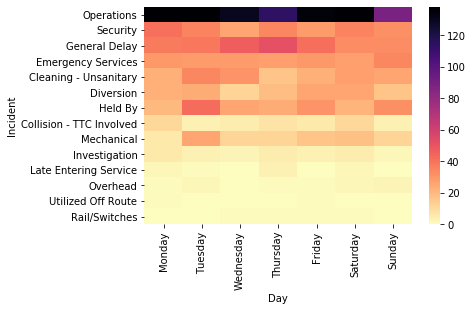

In [24]:
sns.heatmap(dundas, cmap = 'magma_r')

In [ ]:
# Operations was the most common delay across the board, with the fewest happening on Sundays due to reduced service
# Interestingly, even Saturdays were bad for Operations delays, despite also having a reduced service
# General Delays were most common on Thursdays, followed by Wednesdays. Big day for office work, hence more traffic?

In [ ]:
# tl;dr, the TTC streetcar system is in decline, and I'm really hoping their analysts are working off better data than what's available publicly
# Difficult to assess why my streetcar is late, but it's probably "operations"